## ДЗ4. Классификация текста

В качестве заготовки для задания прогоним часть 2ого домашнего задания. Нам необходимо получить разреженные матрицы, используя CountVectorizer, TfidfVectorizer для 'tweet_stemmed' и 'tweet_lemmatized' столбцов (4 матрицы).

Задание 1.
Построим модель LogisticRegression, используя Bag-of-Words признаки для столбца combine_df['tweet_stemmed']. 
- Поделим Bag-of-Words признаки на train, test (train заканчивается на 31962 строке combine_df)
- Ответами является столбец train_df['label']
- Рассчитаем predict_proba, приведем prediction в в бинарный вид: если предсказание >= 0.3 то 1, иначе 0, тип заменим на int
- Рассчитаем f1_score 

Повторим аналогично для столбца combine_df['tweet_lemmatized'].

Задание 2.
Построим модель LogisticRegression, используя TF-IDF признаки для столбца combine_df['tweet_stemmed']. 
- Поделим TF-IDF признаки на train, test (train заканчивается на 31962 строке combine_df)
- Ответами является столбец train_df['label']
- Рассчитаем predict_proba, приведем prediction в в бинарный вид: если предсказание >= 0.3 то 1, иначе 0, тип заменим на int
- Рассчитаем f1_score 

Повторим аналогично для столбца combine_df['tweet_lemmatized'].

Задание 3.
Выведите результаты f1-score всех моделей, сделайте вывод.

Задание 4.
Теперь перейдем к визуализации. Посмотрим, какие слова являются наиболее популярные в датасете с помощью облака слов (WordCloud).
Облако слов - это визуализация, в которой наиболее частые слова большого размера, а менее частые слова меньшего размера.
- объединим слова в одну строку
- создадим словарь частот слов с помощью collections.Counter
- нарисуем облако слов с частотами слов с помощью WordCloud.generate_from_frequencies()
- используем nltk.corpus.stopwords как параметр stopwords, чтобы убрать "мусорные" частотные слова

Задание 5.
Теперь отобразим облако слов для отзывов, не содержащих токсичных комментариев (combine_df['label'] == 0). 

Задание 6.
Теперь отобразим облако слов для отзывов, содержащих токсичные комментарии (combine_df['label'] == 1). 


In [34]:
import re
import numpy as np
import pandas as pd
import pickle

from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import collections
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)
import os
import pickle

In [35]:

df = pd.read_pickle("./words.pkl")
df.head()

,id,label,tweet,clean_tweet,tweet_token,tweet_token_filtered,tweet_stemmed,tweet_lemmatized
0,1,0.0,@user when a father is dysfunctional and is s...,when father is dysfunctional and is so selfish...,"[when, father, is, dysfunctional, and, is, so,...","[father, dysfunctional, selfish, drags, kids, ...","[father, dysfunct, selfish, drag, kid, dysfunc...","[father, dysfunctional, selfish, drag, kid, dy..."
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks for lyft credit cannot use cause they d...,"[thanks, for, lyft, credit, can, not, use, cau...","[thanks, lyft, credit, use, cause, offer, whee...","[thank, lyft, credit, use, caus, offer, wheelc...","[thanks, lyft, credit, use, cause, offer, whee..."
2,3,0.0,bihday your majesty,bihday your majesty,"[bihday, your, majesty]","[bihday, majesty]","[bihday, majesti]","[bihday, majesty]"
3,4,0.0,#model i love u take with u all the time in ...,model love you take with you all the time in ur,"[model, love, you, take, with, you, all, the, ...","[model, love, take, time, ur]","[model, love, take, time, ur]","[model, love, take, time, ur]"
4,5,0.0,factsguide: society now #motivation,factsguide society now motivation,"[factsguide, society, now, motivation]","[factsguide, society, motivation]","[factsguid, societi, motiv]","[factsguide, society, motivation]"


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49159 entries, 0 to 49158
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    49159 non-null  int64  
 1   label                 31962 non-null  float64
 2   tweet                 49159 non-null  object 
 3   clean_tweet           49159 non-null  object 
 4   tweet_token           49159 non-null  object 
 5   tweet_token_filtered  49159 non-null  object 
 6   tweet_stemmed         49159 non-null  object 
 7   tweet_lemmatized      49159 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 3.0+ MB


In [37]:
SPLIT = 31962  #

STEM = 'tweet_stemmed'
LEMM= 'tweet_lemmatized'
TARGET = 'label'

train = df[:int(SPLIT *0.7)]
test = df[int(SPLIT *0.7) : SPLIT]

print(f"Train - {train.shape[0]} samples. Test - {test.shape[0]} samples")

Train - 22373 samples. Test - 9589 samples


In [38]:
def get_embedding(data: pd.Series,
                  vectorizer: callable,
                  parameters: dict = {'max_df': 0.9,
                                      'max_features': 1000,
                                      'stop_words': 'english'}) -> pd.DataFrame:
    
    
    model = vectorizer(**parameters)
    values = model.fit_transform(data.astype('str'))
    feature_names = model.get_feature_names()
    
    return pd.DataFrame(values.toarray(), columns = feature_names)

In [39]:
def eval_model(model: callable,
               X_train: pd.DataFrame,
               y_train: pd.Series,
               X_test: pd.DataFrame,
               y_test: pd.Series,
               eval_metric: callable = f1_score) -> float:
            
    model.fit(X_train, y_train)
    pred_prob = model.predict_proba(X_test)
    y_pred = np.where(pred_prob[:,1]>0.3, 1,0)
    score = f1_score(y_test, y_pred)
    
    return score

In [40]:
TARGET = 'label'

# Stemmed Count Vectorized embedds
X_train_cntvec_stem = get_embedding(train['tweet_stemmed'], vectorizer=CountVectorizer)
X_test_cntvec_stem = get_embedding(test['tweet_stemmed'], vectorizer=CountVectorizer)

# Lemmatized Count Vectorized embedds
X_train_cntvec_lemm = get_embedding(train['tweet_lemmatized'], vectorizer=CountVectorizer)
X_test_cntvec_lemm = get_embedding(test[F'tweet_lemmatized'], vectorizer=CountVectorizer)

# Stemmed TfIdf embedds
X_train_tfidf_stem = get_embedding(train['tweet_stemmed'], vectorizer=TfidfVectorizer)
X_test_tfidf_stem = get_embedding(test['tweet_stemmed'], vectorizer=TfidfVectorizer)

# Lemmatized TfIdf embedds
X_train_tfidf_lemm = get_embedding(train['tweet_lemmatized'], vectorizer=TfidfVectorizer)
X_test_tfidf_lemm = get_embedding(test[F'tweet_lemmatized'], vectorizer=TfidfVectorizer)

y_train = train[TARGET]
y_test = test[TARGET]

In [41]:
X_test_cntvec_stem

,abl,absolut,accept,account,act,action,actor,actual,ad,adapt,...,yesterday,yo,yoga,york,young,youth,youtub,yr,yum,yummi
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9584,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9585,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9586,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9587,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
clf = LogisticRegression()

# CS = CountVec Stemmed, TL = TfIdf Lemmatized
F1_CS = eval_model(clf, X_train_cntvec_stem, y_train, X_test_cntvec_stem, y_test)
F1_CL = eval_model(clf, X_train_cntvec_lemm, y_train, X_test_cntvec_lemm, y_test)
F1_TS = eval_model(clf, X_train_tfidf_stem, y_train, X_test_tfidf_stem, y_test)
F1_TL = eval_model(clf, X_train_tfidf_lemm, y_train, X_test_tfidf_lemm, y_test)

print(f"F1-score: Count Vectorizer Stemmed - {round(F1_CS, 4)}")
print(f"F1-score: Count Vectorizer Lemmatized - {round(F1_CL, 4)}")
print(f"F1-score: TfIdf Vectorizer Stemmed - {round(F1_TS, 4)}")
print(f"F1-score: TfIdf Vectorizer Lemmatized - {round(F1_TL, 4)}")

F1-score: Count Vectorizer Stemmed - 0.076
F1-score: Count Vectorizer Lemmatized - 0.1109
F1-score: TfIdf Vectorizer Stemmed - 0.0323
F1-score: TfIdf Vectorizer Lemmatized - 0.1138


Модель на стемминге отработала гораздо лучше

Задание 4.
Теперь перейдем к визуализации. Посмотрим, какие слова являются наиболее популярные в датасете с помощью облака слов (WordCloud).
Облако слов - это визуализация, в которой наиболее частые слова большого размера, а менее частые слова меньшего размера.
- объединим слова в одну строку
- создадим словарь частот слов с помощью collections.Counter
- нарисуем облако слов с частотами слов с помощью WordCloud.generate_from_frequencies()
- используем nltk.corpus.stopwords как параметр stopwords, чтобы убрать "мусорные" частотные слова

Задание 5.
Теперь отобразим облако слов для отзывов, не содержащих токсичных комментариев (combine_df['label'] == 0). 

Задание 6.
Теперь отобразим облако слов для отзывов, содержащих токсичные комментарии (combine_df['label'] == 1). 

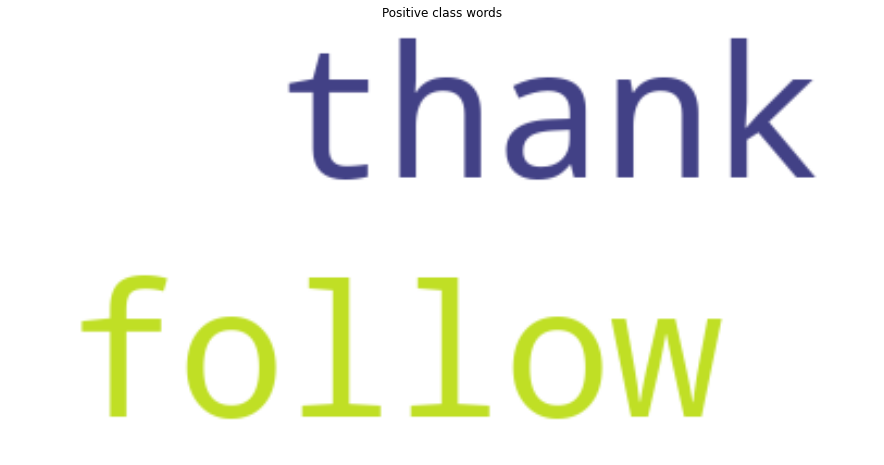

In [43]:

stop_words = set(stopwords.words("english"))

allwords = []
for row in df.loc[df['label'] == 0, 'clean_tweet']: 
    words = [word for word in row.split() if word not in stop_words]
    allwords.extend(words)

word_freq = collections.Counter(words)
wordcloud = WordCloud(
 background_color='white',
 max_words=10000,
 stopwords=stop_words
 ).generate_from_frequencies(word_freq)
plt.figure(figsize=(16,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Positive class words")
plt.show()

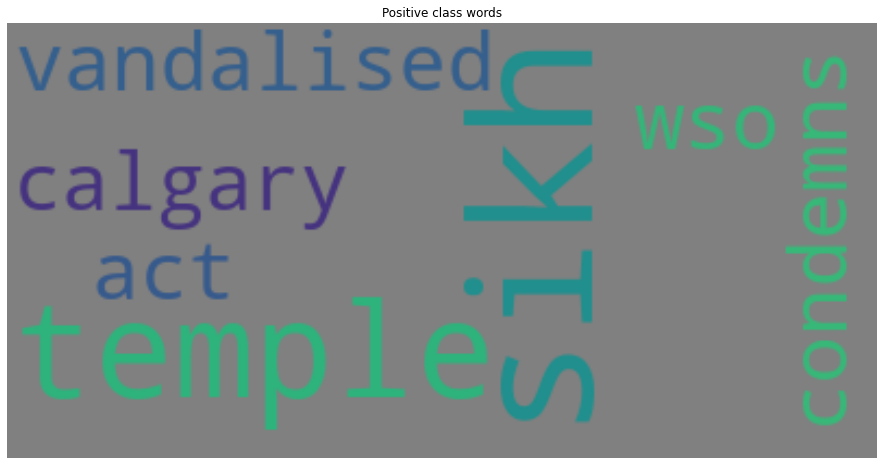

In [44]:
allwords = []
for row in df.loc[df['label'] == 1, 'clean_tweet']:  
    words = [word for word in row.split() if word not in stop_words]
    allwords.extend(words)

word_freq = collections.Counter(words)
wordcloud = WordCloud(
 background_color='grey',
 max_words=10000,
 stopwords=stop_words
 ).generate_from_frequencies(word_freq)
plt.figure(figsize=(16,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Positive class words")
plt.show()